In [2]:
import numpy as np
import pandas as pd
import itertools
import random
import string
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import multiprocess



# RAF

### Pre-processing

In [123]:
def create_kauffman_network (n, t, p, k = 2):
    # Set of Molecules
    X = []
    F = []
    alphabet = string.ascii_uppercase[0:k]
    for i in range(1, n+1):    
        vals = [''.join(m) for m in itertools.product(alphabet, repeat=i)]
        X = X + vals
        if i <= t:
            F = F + vals
    #print(X)
    #print(F)

    # Reaction (pair of molecules)
    R = {}
    react_count = 1
    for i in range(len(X)):
        cand = X[i] + X[i]
        if len(cand) <= n:
            R[react_count] = [[X[i], X[i]], [cand]]
            react_count +=1
            #Lysis Reaction
            R[react_count] = [[cand],[X[i], X[i]]]
            react_count +=1

        for j in range(i+1, len(X)):
            cand1 = X[i] + X[j]
            cand2 = X[j] + X[i]
            if len(cand1) <= n:
                if cand2 != cand1:
                    #print(list(R.values()))
                    if [[X[j], X[i]], [cand1]] not in list(R.values()):
                        R[react_count] = [[X[i], X[j]], [cand1]]
                        react_count +=1
                    
                    if [[cand1],[X[j], X[i]]] not in list(R.values()):
                        R[react_count] = [[cand1],[X[i], X[j]]]
                        react_count +=1
                    
                    if [[X[i], X[j]], [cand2]] not in list(R.values()):
                        R[react_count] = [[X[j], X[i]], [cand2]]
                        react_count +=1
                    
                    if [[cand2],[X[i], X[j]]] not in list(R.values()):
                        R[react_count] = [[cand2],[X[j], X[i]]]
                        react_count +=1
                else:
                    if [[X[j], X[i]], [cand1]] not in list(R.values()):
                        R[react_count] = [[X[i], X[j]], [cand1]]
                        react_count +=1
                    

                    if [[cand1],[X[j], X[i]]] not in list(R.values()):
                        R[react_count] = [[cand1],[X[i], X[j]]]
                        react_count +=1

                   

                # #Addition Reaction
                # R[react_count] = [[X[i], X[j]], [cand1]]
                # react_count +=1

                # if cand2 != cand1:
                #     R[react_count] = [[X[j], X[i]], [cand2]]
                #     react_count +=1

                # #Lysis Reaction
                # R[react_count] = [[cand1],[X[i], X[j]]]
                # react_count +=1

                # if cand2 != cand1:
                #     R[react_count] = [[cand2],[X[j], X[i]]]
                #     react_count +=1


    C = {}
    for i in X:
        for j in range(react_count):
            if np.random.random(1)[0] < p:
                if j%2 == 1:
                    k = 1
                else: 
                    k = -1
                if j in C.keys():
                    C[j].append(i)
                else:
                    C[j]= [i]
                if j+k in C.keys():
                    C[j+k].append(i)
                else:
                    C[j+k]= [i]
                

    return (X, F, R, C)

In [124]:
X,F,R,C = create_kauffman_network(5,1,0.1)

In [125]:
def create_catalysts (X, react_count, p):
    C = {}
    for i in X:
        for j in range(react_count):
            if np.random.random(1)[0] < p:
                if j%2 == 1:
                    k = 1
                else: 
                    k = -1
                if j in C.keys():
                    C[j].append(i)
                else:
                    C[j]= [i]
                if j+k in C.keys():
                    C[j+k].append(i)
                else:
                    C[j+k]= [i]
    return (C)

In [39]:
len(R)

8

In [ ]:
create_catalysts(X, len(R), 0.1)

In [4]:
def graph (X, F, R, C):
    DG = nx.MultiDiGraph()

    for node in X:
   
        if node in F:
            DG.add_node(node, ncolor = "orange")
           
        else:
            DG.add_node(node, ncolor = 'lawngreen')
        

    for node in R: 
        text = "R{}".format(node)
        DG.add_node(text, ncolor = 'salmon')
    

        for i in range(len(R[node][0])):
            DG.add_edge(R[node][0][i], text, color = "steelblue")
        
        for i in range(len(R[node][1])):
            DG.add_edge(text,R[node][1][i], color ="steelblue")
  

    for j in C:
        for k in C[j]:
            if k in X and j in list(R.keys()):
                text = "R{}".format(j)
                DG.add_edge(k, text, color ="fuchsia")




    edge_colors = []

    for (u,v,attrib_dict) in list(DG.edges.data()):
        edge_colors.append(attrib_dict['color'])
    
    node_colors = list(nx.get_node_attributes(DG, "ncolor").values())
    
 


    nx.draw(DG, node_color= node_colors, edge_color = edge_colors, with_labels=True, font_weight='bold', node_size = 750, pos=nx.circular_layout(DG), connectionstyle='arc3, rad = 0.1')
    
    plt.show()

### RAF Algorithm

In [5]:
# Find all possible molecules able to be produced by the food set and available reactions

def closure(F, R):
    no_change = 0
    X = list(F)

    while no_change !=1:
        no_change = 1

        for i in list(R.values()):
            sufficient = 1
            for j in i[0]:
                if j not in X:
                    sufficient = 0
            if sufficient == 1:
                for k in i[1]:
                    if k not in X:
                        X.append(k)
                        no_change = 0
    return(X)
            


In [97]:
closure(F,R)

['A', 'B', 'AA', 'AB', 'BA', 'BB', 'ABA', 'BAA', 'BAB', 'BBA']

In [15]:
def Rsupp (R):
    supp = []
    for i in list(R.values()):
        cands = i[0] + i[1]
        for j in cands:
            if j not in supp:
                supp.append(j)
    return(supp)


In [52]:
R = {1: [['A', 'A'], ['AA']],
 2: [['AA'], ['A', 'A']],
 3: [['A', 'B'], ['AB']],
 5: [['AB'], ['A', 'B']],
 6: [['BA'], ['B', 'A']]}

In [47]:
Rsupp(R)

['A', 'AA', 'B', 'AB', 'BA']

In [53]:
C

{}

In [7]:
# Applies R1: Remove all reactions that are not catalyzed by a molecule involved in our system

def reduceR(R, C):

    catalyzed = list(C.keys())
    uncat_R = list(set(R.keys()) - set(catalyzed))


    for i in uncat_R:
        del R[i]
    
    
    no_change = 0
    while no_change != 1:
        no_change = 1

        suppR= Rsupp(R)
        Rs = list(C.keys())

        for i in Rs:
            for j in C[i]:
                if j not in suppR:
                    C[i] = C[i].remove(j)
                
                if not C[i]:
                    # print("DELETE")
                    del C[i]
                    if i in R:
                        del R[i]
                    no_change = 0
                    break
         
    return(R,C)
            

In [51]:
reduceR(R,C)

({}, {})

In [8]:
def reduceToF(F, R):
    W = closure(F,R)
    r_num= list(R.keys())
    
    for i in r_num:
        remove = 0
        for j in R[i][0]:
            if j not in W:
                remove = 1
                break
        if remove == 1:
            del R[i]

    
    return R

In [9]:
def RAF_pictoral(X,F,R,C):
    X_old = X.copy()
    R_old = copy.deepcopy(R)
    print("Initial")
    graph(X, F, R, C)

    i = 0 
    change = 0
    while change != 1:
        R, C = reduceR(R, C)
       
        X = closure(F,R)

        R = reduceToF(F,R)
        i= i+1

        if R != False and X != False:

            print("Round {}".format(i))

            graph(X, F, R, C)
          
            if X_old == X and R_old == R:
                change = 1
            else:
                R_old = copy.deepcopy(R)
                X_old = X.copy()
        else:
            break

    

In [12]:
def RAF(X,F,R,C):
    X_old = X.copy()
    R_old = copy.deepcopy(R)

    i = 0 
    change = 0
    while change != 1:
        R, C = reduceR(R, C)
        X = closure(F,R)
        R = reduceToF(F,R)
        i= i+1

        if R != False and X != False:
            if X_old == X and R_old == R:
                change = 1
            else:
                R_old = copy.deepcopy(R)
                X_old = X.copy()
        else:
            break
    
    if not R:
        return 0
    else:
        return 1
    

# Examples

## Hordjik04 Example

In [98]:
X = [''.join(i) for i in itertools.product(string.ascii_uppercase, repeat=2)][0:7]
R = {1: [["AA", "AB"], ["AC"]],
    2: [["AB", "AC"], ["AD"]],
    3: [["AC", "AD"], ["AE", "AF"]],
    4: [["AA", "AE"], ["AG"]],
 }
F = ["AA", "AB"]
C = { 1:["AD"], 2:["AA"], 4:["AF"] }

Initial


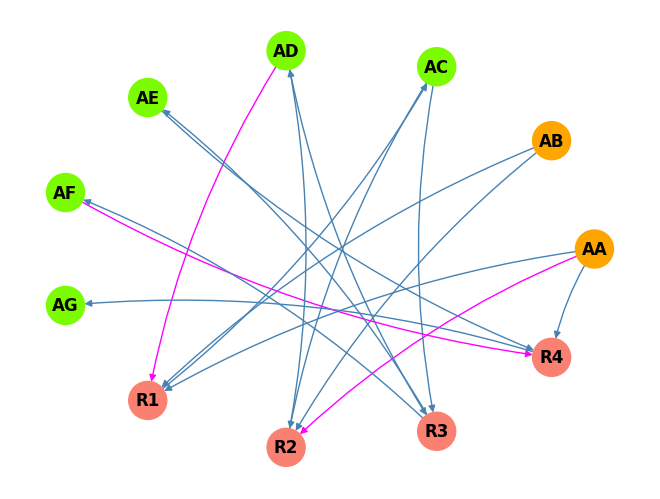

Round 1


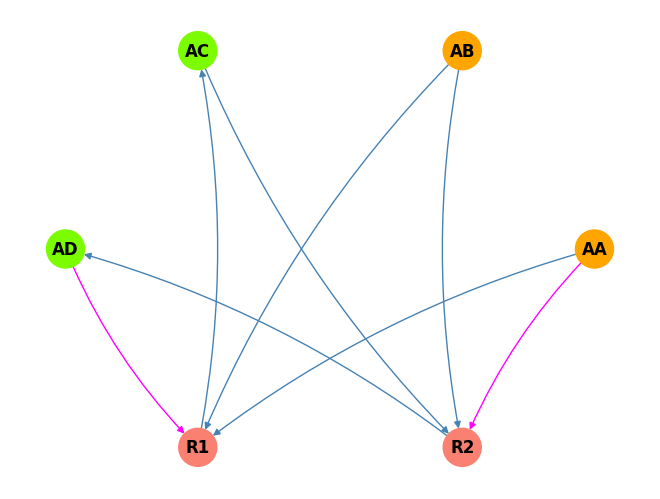

Round 2


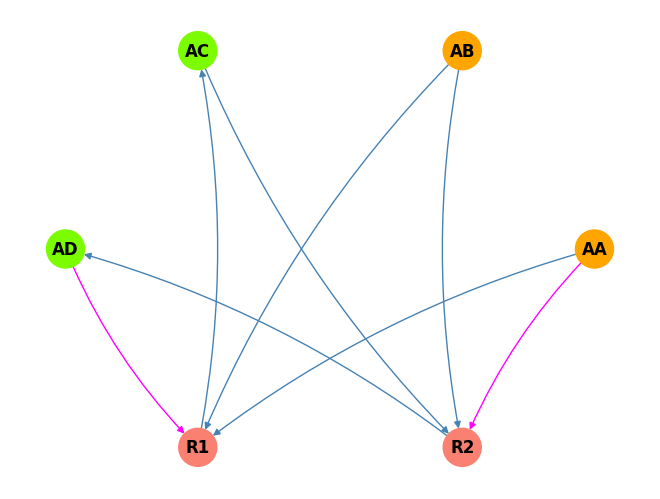

In [99]:
RAF_pictoral(X, F, R,C)

In [13]:
RAF(X,F,R,C)

1

## Kauffman Model

In [126]:
X,F,R,C = create_kauffman_network(3,2,0.02)

Initial


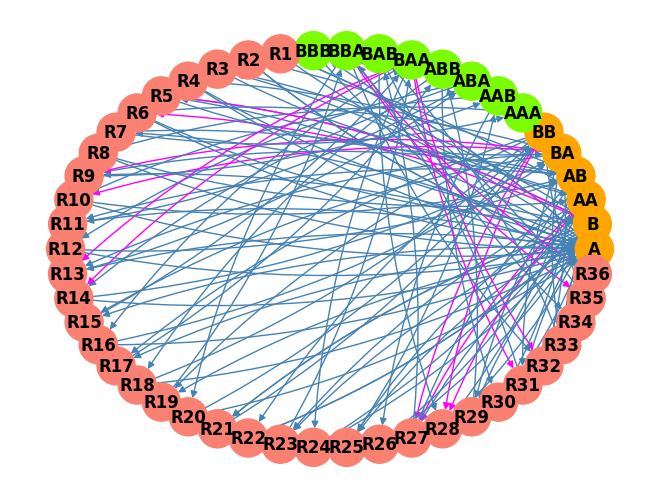

Round 1


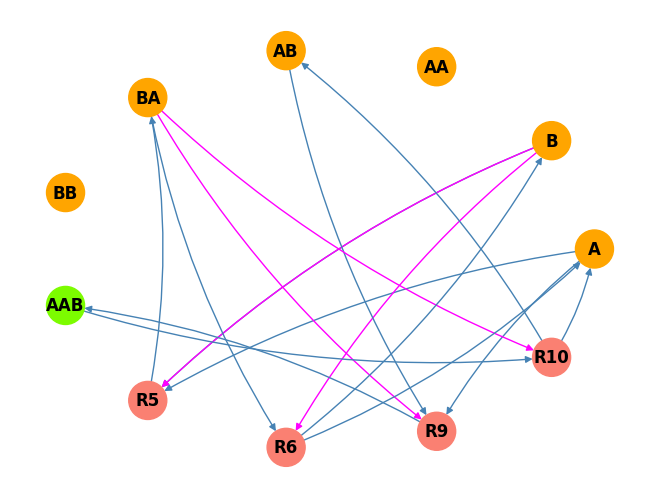

Round 2


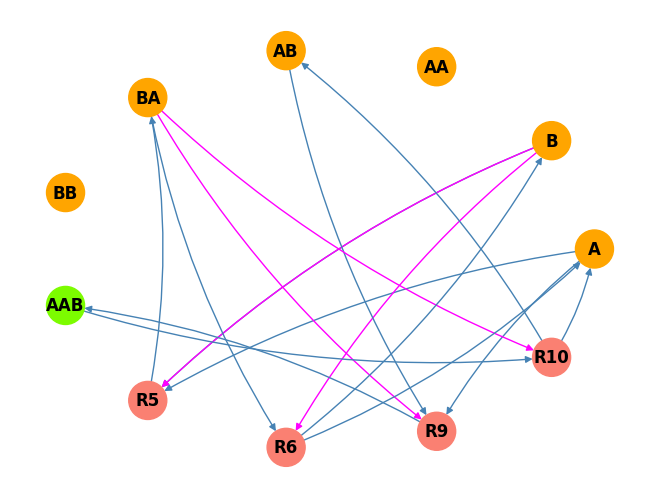

In [127]:
RAF_pictoral(X,F,R,C)

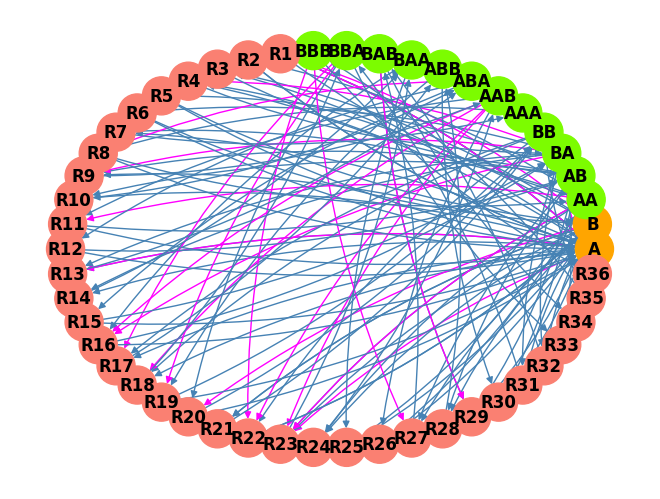

In [82]:
graph(X,F,R,C)

In [80]:
RAF(X,F,R,C)

0

# Hordjik04 Simulation

In [38]:
def RAF_sim(Ns, ns, t, f_max, reps=50):
    plt.figure(figsize=(8,8))
    for i in tqdm(range(len(ns))):
        X,F,R,C = create_kauffman_network(ns[i], 0, 0)
        R_size = len(R)
        p_max = f_max/R_size
        ps = np.linspace(0,p_max, reps)
        Xs = []
        Ys= []
        for p in ps:
            raf_count = 0
            for k in range(Ns[i]):
                X,F,R,C = create_kauffman_network(ns[i], t, p)
                raf_count = RAF(X,F,R,C) + raf_count

            Xs.append(p*R_size)
            Ys.append(raf_count/Ns[i])
        
        plt.plot(Xs,Ys, "-o", label= "n = {}".format(ns[i]))

    plt.legend()
    plt.xlabel("Expected Number of Catalysts")
    plt.ylabel("Probability of RAF Set")
    plt.title("Hordjik04 Probability Simulation")
    plt.show()




100%|██████████| 3/3 [02:47<00:00, 55.81s/it]


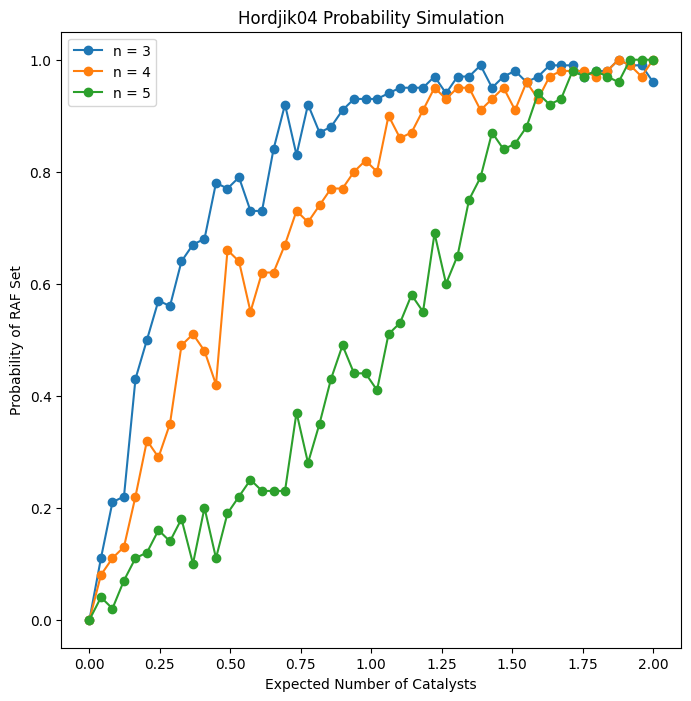

In [131]:
RAF_sim([100,100,100], [3,4,5], 2,2)

### Multiprocessing

In [37]:
def RAF_pool_sim_helper(N, n, t, f_max, reps=50):
    
    
    X,F,R,C = create_kauffman_network(n, t, 0)
    R_size = len(R)
    #print(R_size)
    p_max = f_max/R_size
    ps = np.linspace(0,p_max, reps)
    #print(ps)
    Xs = []
    Ys= []

    for p in tqdm(ps):
        raf_count = 0
        for k in range(N):
            X_new= X.copy()
            R_new = copy.deepcopy(R)
            C_new = create_catalysts(X_new, R_size, p)

            # print(X_new)
            # print(R_new)
            # print(C_new)
            # print(F)
            # print("---------------------")
            #X,F,R,C = create_kauffman_network(n, t, p)
            raf_count = RAF(X_new,F,R_new,C_new) + raf_count

        Xs.append(p*R_size)
        Ys.append(raf_count/N)
    
    return (Xs, Ys, n)

In [39]:
def RAF_pool_sim_helper_dummy(N, n, t, f_max, reps=50):
    
    
    X,F,R,C = create_kauffman_network(n, t, 0)
    R_size = len(R)
    #print(R_size)
    p_max = f_max/R_size
    ps = np.linspace(0,p_max, reps)
    #print(ps)
    Xs = []
    Ys= []

    for p in tqdm(ps):
        raf_count = 0
        for k in range(N):
            # X_new= X.copy()
            # R_new = copy.deepcopy(R)
            # C_new = create_catalysts(X_new, R_size, p)
            X,F,R,C = create_kauffman_network(n, t, p)

            # print(X_new)
            # print(R_new)
            # print(C_new)
            # print(F)
            # print("---------------------")
            #X,F,R,C = create_kauffman_network(n, t, p)
            raf_count = RAF(X,F,R,C) + raf_count

        Xs.append(p*R_size)
        Ys.append(raf_count/N)
    
    return (Xs, Ys, n)

In [40]:
def RAF_pool_sim(Ns, ns, t, f_max, reps = 50):
    plt.figure(figsize=(8,8))
    pool = multiprocess.Pool()

    with pool as p:
        vals = []
        for i in range(len(Ns)):
            vals = vals + [(Ns[i], ns[i], t, f_max, reps)]
        
        for result in p.starmap(RAF_pool_sim_helper, vals):
            plt.plot(result[0],result[1], "-o", label= "n = {}".format(result[2]))

    plt.legend()
    plt.xlabel("Expected Number of Catalyzed Reaction per molecule")
    plt.ylabel("Probability of RAF Set")
    plt.title("Hordjik04 Probability Simulation")
    plt.show()
    
    


100%|██████████| 50/50 [23:28<00:00, 28.16s/it]


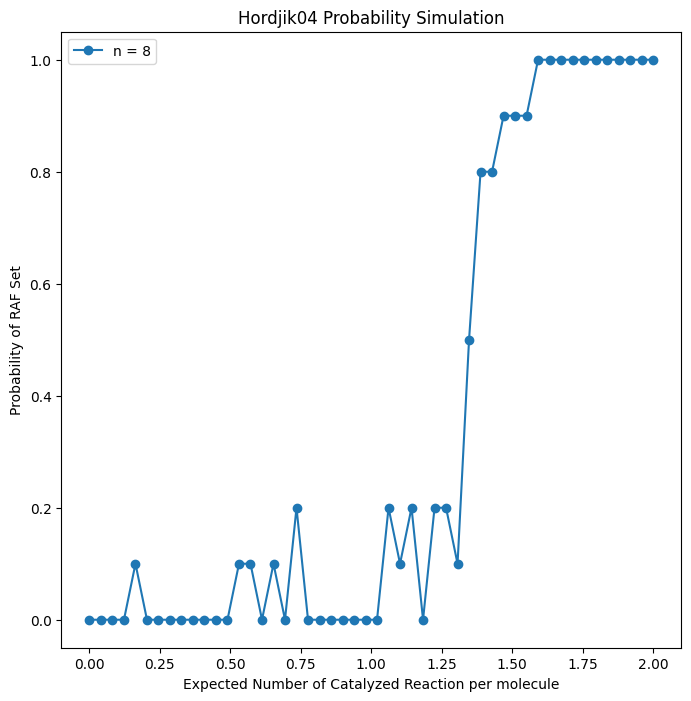

In [132]:
RAF_pool_sim([10], [8], 2,2)